# 1. Install Dependencies

In [1]:
%pip install gym 'gym[atari]'
%pip install torch torchvision torchaudi6
%pip install matplotlib
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement torchaudi6 (from versions: none)
ERROR: No matching distribution found for torchaudi6
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 2. Import Dependencies

In [18]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import ResizeObservation, GrayScaleObservation

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output

import time
import os

import torch
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# 3. Utils

In [13]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        #print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        # Pause animation
        time.sleep(time_lag)

In [27]:
def store_episode_as_gif(experience_buffer, filepath='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(filepath, writer='imagemagick', fps=fps)

# 4. Create Base Environment

In [3]:
base_env = gym.make('ALE/Pitfall-v5', render_mode='rgb_array')
if base_env.reset():
    print('Environment is ready!')

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Environment is ready!


State space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(18)
Action space: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Action: 13
Reward: 0.0
State done :False
State info :{'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


/home/rubensas/anaconda3/envs/MEI_SI/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


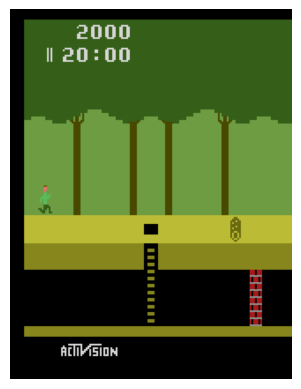

In [4]:
def show_env_info(env):
    # Print dimensions of state and action space
    print("State space: {}".format(base_env.observation_space))
    print(f"Action space: {env.action_space}")
    print(f"Action space: {env.unwrapped.get_action_meanings()}")

    # Sample random action
    action =env.action_space.sample()
    print("Action: {}".format(action))
    next_state, reward, done, _, info = env.step(action)

    # Print output
    print("Reward: {}".format(reward))
    print(f"State done :{done}")
    print(f"State info :{info}")

    # Render and plot an environment frame
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

show_env_info(base_env)

# 5. Customize Environment

In [5]:
class CustomEnv(gym.Wrapper):

    def __init__(self, env):
        super(CustomEnv, self).__init__(env)
        self.env = env
        self.lives = 3
    
    def step(self, action):
        next_state, reward, done, truncated, info = self.env.step(action)
        self.lives = info['lives']
        return next_state, reward, done, truncated, info

env = CustomEnv(ResizeObservation(base_env,(130,130)))
env = GrayScaleObservation(env, keep_dim=True)
if env.reset():
    print('Custom Environment is ready!')

Custom Environment is ready!


# 6. Custom Model

In [6]:
# Print dimensions of state and action space
height, width, channels = env.observation_space.shape
print(f"Height: {height}, Width: {width}, Channels: {channels}")

# Print action space and number of actions
n_actions = env.action_space.n
actions = env.unwrapped.get_action_meanings()
print(f"Number of actions: {n_actions}, Actions: {actions}")

Height: 130, Width: 130, Channels: 1
Number of actions: 18, Actions: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [7]:
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = torch.nn.Sequential(torch.nn.Linear(n_flatten, features_dim), torch.nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [8]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [9]:
class TensorboardCallback(BaseCallback):
    def __init__(self, log_dir, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.writer = SummaryWriter(log_dir=log_dir)

    def _on_step(self) -> bool:
        # Log training metrics
        self.writer.add_scalar("Loss", self.locals["values"].item(), self.num_timesteps)
        self.writer.add_scalar("Reward", self.locals["rewards"][0], self.num_timesteps)

        return True

    def _on_training_end(self) -> None:
        # Close the SummaryWriter after training
        self.writer.close()

# Specify the log directory where TensorBoard files will be saved
log_dir = "logs/"

# Create a TensorboardCallback
tensorboard_callback = TensorboardCallback(log_dir=log_dir)

In [10]:
# Train the agent
model.learn(total_timesteps=100, callback=tensorboard_callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 940      |
|    ep_rew_mean     | -158     |
| time/              |          |
|    fps             | 236      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------


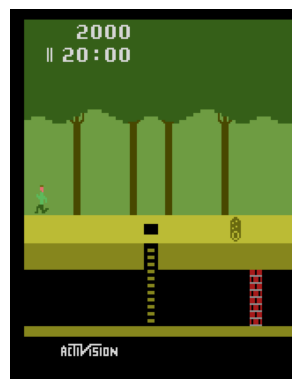

Episode: 1/1
Epoch: 99/99
Action: 17
Reward: 0.0


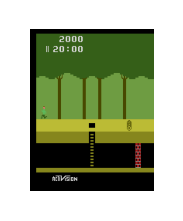

In [28]:
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False
min_reward = 0

for epoch in range(1, 100):
    # Reset environment
    state = env.reset()
    cum_reward = 0
    done = False

    # Select random action
    action = env.action_space.sample()

    # Perform action
    next_state, reward, done, _, info = env.step(action)
    cum_reward += reward

    # Render environment
    env.render()

    # Save experience in buffer
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    # Update state
    state = next_state


# Run animation and print console output
run_animation(experience_buffer)
store_episode_as_gif(experience_buffer, "animation.gif")